In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Mission 2
### a - Decide Validation strategy

Our validation strategy works in the form of ***sliding windows***. The reason we used this strategy is because if we use the K-Fold group 
we predicted that an overfitting situation could arise in the training set. 
Our training set consists of subjects {101:106,109} and the test set consists of subjects {107,108} as we required.
In order to adapt the training set that will be a relevant bench mark in the future to the Lstm model we are interested in creating, we divided
the training set into a sequence with a window size of 400, with a stride size of 100 (non-overlapping between the windows).

In [2]:
# Dict for activities
number_to_activity ={ 
        '0': 'other'
        ,'1': 'lying'
        ,'2': 'sitting'
        ,'3': 'standing'
        ,'4': 'walking'
        ,'5': 'running'
        ,'6': 'cycling'
        ,'7': 'Nordic walking'
        ,'9': 'watching TV'
        ,'10':'computer work'
        ,'11':'car driving'
        ,'12':'ascending stairs'
        ,'13':'descending stairs'
        ,'16':'vacuum cleaning'
        ,'17':'ironing'
        ,'18':'folding laundry'
        ,'19':'house cleaning'
        ,'20':'playing soccer'
        ,'21':'rope jumping'
        }
activity_to_number ={ 
         'other':'0' 
        ,'lying':'1' 
        ,'sitting':'2' 
        ,'standing':'3' 
        ,'walking':'4' 
        ,'running':'5' 
        ,'cycling':'6' 
        ,'Nordic walking':'7' 
        ,'watching TV':'9' 
        ,'computer work':'10'
        ,'car driving':'11' 
        ,'ascending stairs':'12' 
        ,'descending stairs':'13' 
        ,'vacuum cleaning':'16' 
        ,'ironing':'17' 
        ,'folding laundry':'18' 
        ,'house cleaning':'19' 
        ,'playing soccer':'20' 
        ,'rope jumping':'21' 
        }


In [6]:
def read_data_and_preprocessing():
    data ={}
    columns_name = [
    'timestamp','activityID', 'heart-rate',
    # IMU hand
    'hand-temperature',
    'hand-acc-x','hand-acc-y', 'hand-acc-z', 
    'hand-x6','hand-y6', 'hand-z6',
    'hand-gyr-x','hand-gyr-y', 'hand-gyr-z',
    'hand-mag-x','hand-mag-y', 'hand-mag-z',
    # IMU chest 
    'chest-temperature',
    'chest-acc-x','chest-acc-y', 'chest-acc-z', 
    'chest-x6','chest-y6', 'chest-z6',
    'chest-gyr-x','chest-gyr-y', 'chest-gyr-z',
    'chest-mag-x','chest-mag-y', 'chest-mag-z',
    # IMU ankle
    'ankle-temperature',
    'ankle-acc-x','ankle-acc-y', 'ankle-acc-z', 
    'ankle-x6','ankle-y6', 'ankle-z6',
    'ankle-gyr-x','ankle-gyr-y', 'ankle-gyr-z',
    'ankle-mag-x','ankle-mag-y', 'ankle-mag-z']
    
    for subject_number in range(101,110):
        datContent = [i.split() for i in open(f'Protocol\subject{subject_number}.dat').readlines()] #Reading the date 
        # drop out orientation from all IMU sensors
        # data[3:17] #IMU chest data without orientation 
        # data[20:34] #IMU chest data without orientation 
        # data[37:51]  #IMU ankle data without orientation 
        datContent = [np.concatenate((row[:16],row[20:33],row[37:50])) for row in datContent]
        df = pd.DataFrame(datContent, columns=columns_name)
        # transform all columns from str to numeric
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df = df.drop(columns=['hand-x6','hand-y6', 'hand-z6','chest-x6','chest-y6', 'chest-z6','ankle-x6','ankle-y6', 'ankle-z6'])
        df['activityID'] = np.where(df['activityID']==24,21,df['activityID'])  # change rope jumping activityID from 24 to 22 
        
        data[subject_number] = df   # add subject's dataframe to dictionary  
        
    return data

Read only first time

In [4]:
#subjects_data = read_data_and_preprocessing()

In [5]:
# saving the data for future work
# with open('subjects_data_new.pickle', 'wb') as f:
#     pickle.dump(subjects_data, f)

**Loading pickled file**

In [3]:
with open('subjects_data_new.pickle', 'rb') as handle:
    loaded_file = pickle.load(handle)

In [4]:
import torch
# import neptune.new as neptune
from sklearn import metrics

c:\Users\Ziv Yogev\Desktop\Programming\WPDL\Lesson7\MyVenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Function for create sequences
def sliding_window(df, window_size, stride):
    data = df.copy()
    data = data.reset_index(drop=True)
    data = data.to_numpy()
    data_list = []
    for i in range(0, len(data), stride):
        if i + window_size < len(data):
            data_list.append(data[i:i+window_size])
        else:
            return torch.Tensor(data_list)

#Function to interpolate NaNs because we want to keep the data continuous
def interpolate_nans(df):
    df = df.interpolate(method='linear', axis=0).ffill().bfill()
    return df

**Sliding windows for train & test data**

In [6]:
train_data = {}
keys = loaded_file.keys()
keys = [key for key in keys if key not in [107,108]]
list_of_classes = list(number_to_activity.keys())

window_size = 400
stride = 100

for key in keys:
    print(f"Now reading subject number {key}")
    df = loaded_file[key].copy()
    for label in list_of_classes:
        # Should perform different sliding windows here per subject
        new_data = df[df['activityID'] == int(label)]
        # Interpolate NaNs per subject per activity ( No mixup of data)
        new_data = interpolate_nans(new_data)
        # Sliding window per subject per activity
        train_data[key,label] = sliding_window(new_data, window_size, stride)

Now reading subject number 101


C:\Users\Ziv Yogev\AppData\Local\Temp\ipykernel_19088\2481781256.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  return torch.Tensor(data_list)


Now reading subject number 102
Now reading subject number 103
Now reading subject number 104
Now reading subject number 105
Now reading subject number 106
Now reading subject number 109


In [7]:
test_data = {}
keys = [107,108]
list_of_classes = list(number_to_activity.keys())

window_size = 400
stride = 100

for key in keys:
    print(f"Now reading subject number {key}")
    df = loaded_file[key].copy()
    for label in list_of_classes:
        # Should perform different sliding windows here per subject
        new_data = df[df['activityID'] == int(label)]
        # Interpolate NaNs per subject per activity ( No mixup of data)
        new_data = interpolate_nans(new_data)
        # Sliding window per subject per activity
        test_data[key,label] = sliding_window(new_data, window_size, stride)

Now reading subject number 107
Now reading subject number 108


In [8]:
def calc_trend(df,feature):
    if df[-1,feature] > df[0,feature]:
        return 1
    else:
        return 0

**Create X_train & X_test**

In [114]:
def pre_training(data, Subjects):
    pretraining_df = data
    #Pool the data together for each activity
    subjects = Subjects

    X = {}

    activities = ["0","1","2","3","4","5","6","7","9","10","11","12","13","16","17","18","19","20","21"]
    #Pool the data together for each activity
    for activity in activities:
        X[activity] = torch.empty(0,400,33) 
        for subject in subjects:
            if pretraining_df[(subject,activity)] is not None :
                X[activity] = torch.cat((X[activity],pretraining_df[(subject,activity)]),0)
                
    y_t= []
    X_t = []
    for act in activities:
        for sequence in X[act]:
            X_t.append(sequence[:,2:]) # drop time stamp and activity ID
            y_t.append(int(act))

    # change tensor to dataframe
    for i in range(len(X_t)):
        X_t[i] = pd.DataFrame(X_t[i])

    return X_t, y_t

In [96]:
subject_train = [101,102,103,104,105,106,109]
X_train, y_train = pre_training(train_data, subject_train)
subject_test = [107,108]
X_test, y_test = pre_training(test_data, subject_test)

### 2.b - Creating a Naïve baseline based on the heart rate data
**Calculate heart rate statistics for training data**

In [11]:
from math import sqrt
all_means = {}
means = {}
stdev = {}
for i in np.unique(y_test):
    all_means[i], means[i], stdev[i] = [], [], np.float16()
for sequence in X_train:
    mean = sequence[1].mean() # mean of heart rate of sequence
    all_means[int(sequence[0][0])].append(mean)
for i in all_means: # calculate mean for each activity
    means[i] = sum(all_means[i])/len(all_means[i]) # calculate mean for activity
    stdev[i] = sqrt(sum([(x - means[i])**2 for x in all_means[i]]) / float(len(all_means[i]))) # calculate std.v for activity
    print(f'Heart Rate description for activity {i} -  mean is: {means[i]}, STD.V is: {stdev[i]} for {len(all_means[i])} sequences')

Heart Rate description for activity 0 -  mean is: 114.86604052553989, STD.V is: 20.400230565868892 for 7004 sequences
Heart Rate description for activity 1 -  mean is: 77.35717763127508, STD.V is: 10.686020662856096 for 1406 sequences
Heart Rate description for activity 2 -  mean is: 81.16737353333923, STD.V is: 7.406358594084922 for 1478 sequences
Heart Rate description for activity 3 -  mean is: 92.31642126932631, STD.V is: 8.340661678594206 for 1370 sequences
Heart Rate description for activity 4 -  mean is: 113.90937763358691, STD.V is: 8.729283553929033 for 1715 sequences
Heart Rate description for activity 5 -  mean is: 156.73197876255443, STD.V is: 19.192232008845 for 766 sequences
Heart Rate description for activity 6 -  mean is: 125.75555712182276, STD.V is: 9.034944422080137 for 1146 sequences
Heart Rate description for activity 7 -  mean is: 124.27126142713759, STD.V is: 11.149840518142723 for 1287 sequences
Heart Rate description for activity 12 -  mean is: 130.765135524428

**Calculate mean of heart rate for X_test**

In [12]:
# return activity by MAE from mean heart rate of activity
def find_min_dist(mean):
    min = np.inf
    for x in all_means:
        temp = abs(mean-means[x])
        if temp < min:
            min = temp
            activity = x
    return activity


In [13]:
pred_test = []
for sequence in X_test:
    mean = sequence[0].mean() # mean of heart rate of sequence
    activity_test = find_min_dist(mean) # min distance from all activities heart rate mean
    pred_test.append(activity_test)

              precision    recall  f1-score   support

           0       0.29      0.05      0.09      2261
           1       0.33      0.91      0.48       491
           2       0.03      0.05      0.03       345
           3       0.03      0.03      0.03       502
           4       0.06      0.02      0.04       646
           5       0.06      0.07      0.06       195
           6       0.24      0.09      0.13       474
           7       0.27      0.38      0.32       569
          12       0.14      0.27      0.18       286
          13       0.01      0.00      0.01       206
          16       0.18      0.37      0.24       451
          17       0.36      0.29      0.32       617
          21       0.13      0.69      0.22        85

    accuracy                           0.19      7128
   macro avg       0.16      0.25      0.17      7128
weighted avg       0.21      0.19      0.16      7128

Naive baseline accuracy on test: 19.29 %


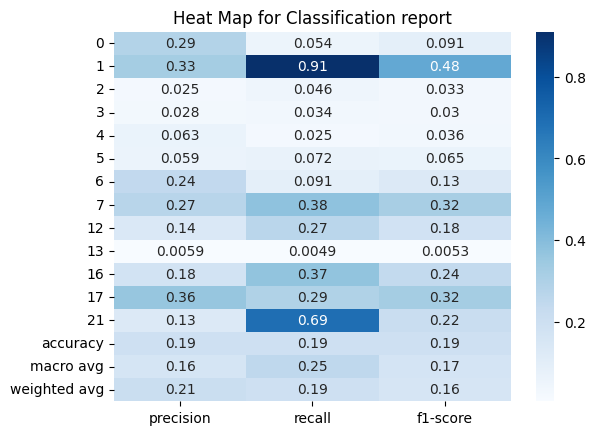

In [195]:
# plot classification report
import seaborn as sns

naive_report = metrics.classification_report(y_test,pred_test, output_dict=True)
ax = plt.axes()
sns.heatmap(pd.DataFrame(naive_report).iloc[:-1, :].T, annot=True, cmap = "Blues", ax = ax)
ax.set_title('Heat Map for Classification report')
print(metrics.classification_report(y_test,pred_test))
print(f'Naive baseline accuracy on test: {round(metrics.accuracy_score(y_test,pred_test)*100,3)} %')

Text(0.5, 1.0, 'Confusion matrix by Activity')

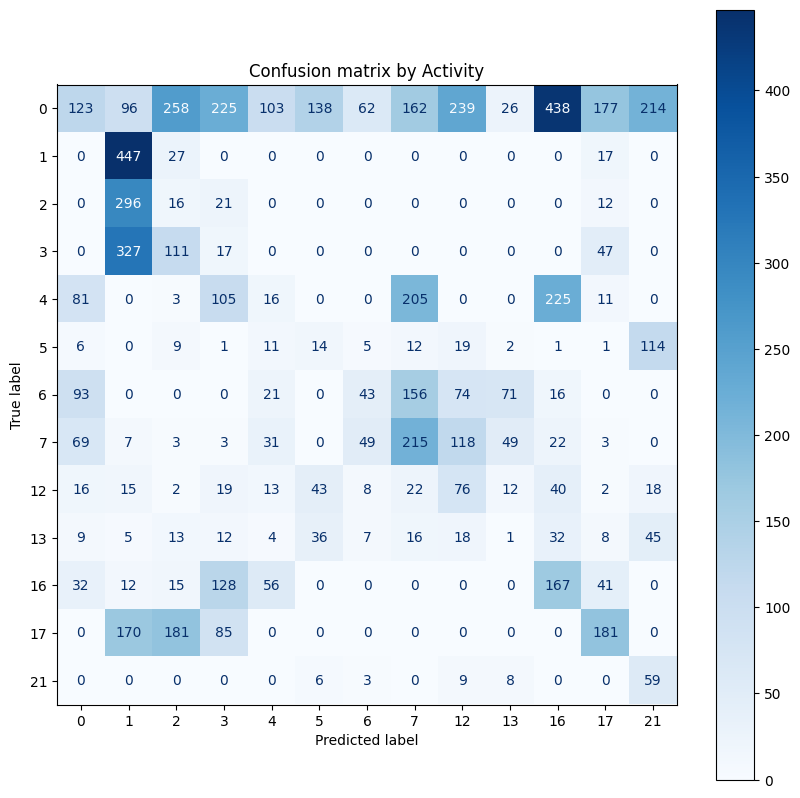

In [188]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(y_test,pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,display_labels=np.unique(y_test))
fig, ax = plt.subplots(figsize = (10,10))
disp.plot(cmap="Blues", ax=ax)
plt.title("Confusion matrix by Activity")

### 2.c - Classical ML model - Random Forest

In [115]:
X_train, y_train = pre_training(train_data, subject_train)
X_test, y_test = pre_training(test_data, subject_test)

In [155]:
# Function to create a new df with means from all attributes
def create_mean_df(df):
    temp_df = pd.DataFrame(index = range(len(df)), columns= range(31)) # create df by size of sequences in data
    for i,sequence in enumerate(df):
        mean = sequence.mean() # mean of sequence
        temp_df.loc[i] = mean # append mean of sequences to df
    return temp_df

In [156]:
X_train = create_mean_df(X_train)
X_test = create_mean_df(X_test)

In [159]:
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
clf=RandomForestClassifier(max_depth=10, n_estimators=10, max_features="sqrt")

#Train the model using the training set
clf.fit(X_train,y_train)
print("Model are finish to train!")

y_pred=clf.predict(X_test)

Model are finish to train!


              precision    recall  f1-score   support

           0       0.48      0.93      0.64      2261
           1       0.97      0.96      0.97       491
           2       0.96      0.76      0.85       345
           3       0.70      0.41      0.52       502
           4       0.84      0.41      0.55       646
           5       1.00      0.13      0.24       195
           6       1.00      0.68      0.81       474
           7       0.89      0.33      0.48       569
          12       0.89      0.44      0.59       286
          13       0.00      0.00      0.00       206
          16       0.98      0.41      0.58       451
          17       0.89      0.73      0.80       617
          21       0.00      0.00      0.00        85

    accuracy                           0.65      7128
   macro avg       0.74      0.48      0.54      7128
weighted avg       0.73      0.65      0.62      7128

Random Forest accuracy on test: 64.717 %


Text(0.5, 1.0, 'Heat Map for Classification report')

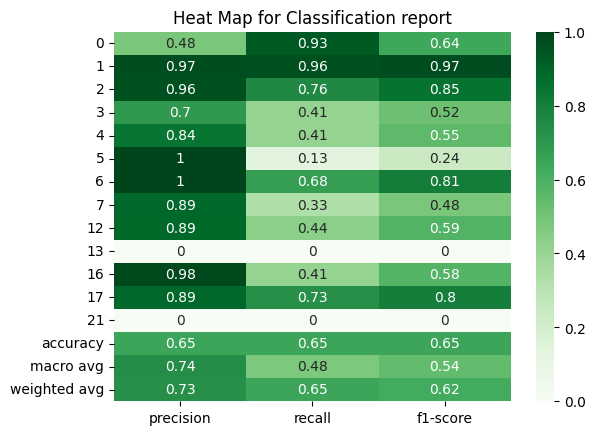

In [194]:
import warnings
warnings.filterwarnings('ignore')
clf_report = metrics.classification_report(y_test,y_pred, output_dict=True)
print(metrics.classification_report(y_test,y_pred))
# Model Accuracy, how often is the classifier correct
print(f'Random Forest accuracy on test: {round(metrics.accuracy_score(y_test,y_pred)*100,3)} %')
ax = plt.axes()
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap = "Greens", ax = ax)
ax.set_title('Heat Map for Classification report')

Text(0.5, 1.0, 'Confusion Matrix By Activity')

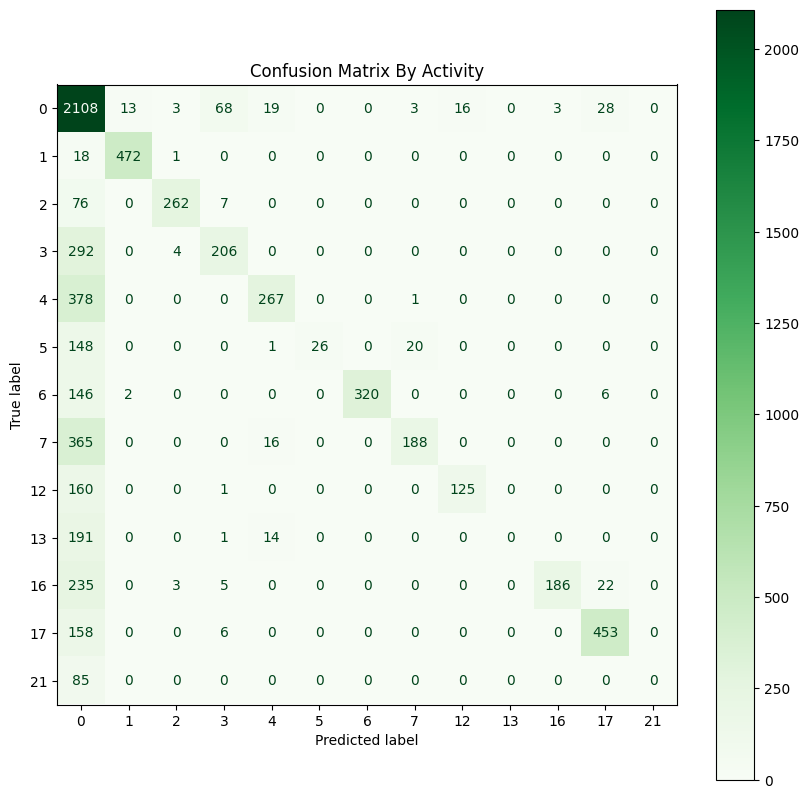

In [187]:
cm = metrics.confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize = (10,10))
disp.plot(cmap="Greens", ax=ax)

plt.title("Confusion Matrix By Activity")